In [1]:
import sys
import os
import re
import time
import datetime
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

sys.path.append('/Users/syz/PycharmProjects/pyUSID/')
import pyUSID as usid

time_str_to_num = partial(usid.io_utils.formatted_str_to_number, 
                          magnitude_names=['msec', 'sec', 'mins', 'hours'], 
                          magnitude_values=[0.001, 1, 60, 3600], separator=' ')

def parse_compute_line(line):
    # Rank 53 - computed chunk in 2.61 mins or 147.0 msec per pixel. Average: 147.0 msec per pixel.
    matchObj = re.match(r'Rank (.*) - computed chunk in (.*) or (.*) per pixel. Average: (.*) per pixel.', line, re.M|re.I)
    type_list = [int, str, str, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the third value - time per pixel
        return time_str_to_num(raw_vals[2])
    else:
        return None
    
def parse_write_line(line):
    # Rank 28 - wrote its 1064 pixel chunk in 6.42 sec
    matchObj = re.match(r'Rank (.*) - wrote its (.*) pixel chunk in (.*)', line, re.M|re.I)
    type_list = [int, int, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        return time_str_to_num(raw_vals[2]) / raw_vals[1]
    else:
        return None
    
def parse_execution_time(line):
    # Execution time: 167.08025765419006 sec
    matchObj = re.match(r'Execution time: (.*) sec', line, re.M|re.I)
    type_list = [float]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        return raw_vals[0]
    else:
        return None
    
def parse_log_filename(line, prefix):
    # Execution time: 167.08025765419006 sec
    matchObj = re.match(prefix + r'N(.*)R(.*)\.(.*)', line, re.M|re.I)
    type_list = [int, int, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        return raw_vals[:2]
    else:
        return None
    
def parse_console_logs(file_path):
    compute_times = list()
    write_times = list()
    total_time = None
    with open(file_path,mode='r') as file_handle:
        console_output = file_handle.readlines()
        for curr_line in console_output:
            ret_val = parse_compute_line(curr_line)
            if ret_val is not None:
                compute_times.append(ret_val)
                continue
            ret_val = parse_write_line(curr_line)
            if ret_val is not None:
                write_times.append(ret_val)
                continue
            ret_val = parse_execution_time(curr_line)
            if ret_val is not None:
                # Should only come here once
                total_time = ret_val
    return compute_times, write_times, total_time

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
mpi_ranks = []
mpi_compute_mean = []
mpi_compute_std = []
mpi_write_mean = []
mpi_write_std = []
mpi_total_times = []

prefix = 'GivBenchmark'
for file_name in os.listdir('.'):
    if not file_name.startswith(prefix): 
        continue
    nodes, ranks_per_node = parse_log_filename(file_name, prefix)
    compute_times, write_times, tot_time = parse_console_logs(file_name)
    
    mpi_ranks.append(nodes * ranks_per_node)
    mpi_compute_mean.append(np.mean(compute_times))
    mpi_compute_std.append(np.std(compute_times))
    mpi_write_mean.append(np.mean(write_times))
    mpi_write_std.append(np.std(write_times))
    mpi_total_times.append(tot_time)

# This can be of any order so sort based on ranks:
sort_order = np.array(mpi_ranks).argsort()

mpi_ranks = np.array(mpi_ranks)[sort_order]
mpi_compute_mean = np.array(mpi_compute_mean)[sort_order]
mpi_compute_std = np.array(mpi_compute_std)[sort_order]
mpi_write_mean = np.array(mpi_write_mean)[sort_order]
mpi_write_std = np.array(mpi_write_std)[sort_order]
mpi_total_times = np.array(mpi_total_times)[sort_order]

In [3]:
num_jobs = 68096
tot_time_per_pixel = np.array(mpi_compute_mean) + np.array(mpi_write_mean)
estimated_serial_time = num_jobs * tot_time_per_pixel
mpi_estimated_parallel_time = estimated_serial_time / np.array(mpi_ranks)

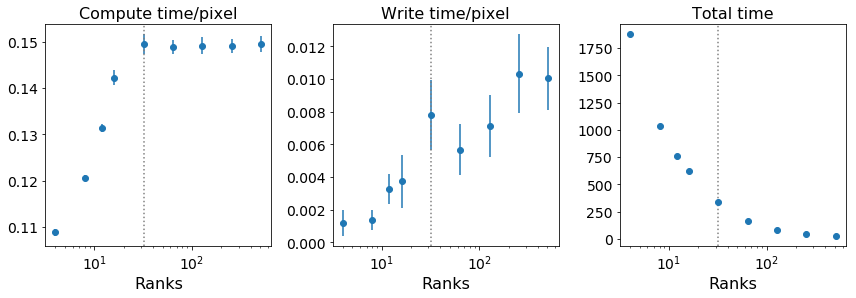

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4.25))
axes.flat[0].set_ylabel('Time (sec)', fontsize=16)
for axis, mean_vals, std_vals, qty_name in zip(axes.flat, 
                                              [mpi_compute_mean, mpi_write_mean, mpi_total_times],
                                              [mpi_compute_std, mpi_write_std, [0 for item in mpi_total_times]],
                                              ['Compute time/pixel/worker', 'Write time/pixel', 'Total time']):
    #axis.scatter(ranks, mean_vals)
    axis.errorbar(mpi_ranks, mean_vals, yerr=std_vals, fmt='o')
    axis.set_xscale('log')
    axis.axvline(x=32, color='grey', ls=':')
    axis.set_title(qty_name, fontsize=16)
    axis.set_xlabel('Ranks', fontsize=16)
    
usid.plot_utils.set_tick_font_size(axes, 14)
fig.tight_layout()

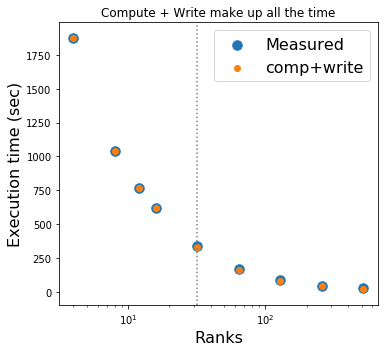

In [5]:
fig, axis = plt.subplots(figsize=(5.5, 5))
axis.scatter(mpi_ranks, mpi_total_times, s=90, label='Measured')
axis.scatter(mpi_ranks, mpi_estimated_parallel_time, label='comp+write')
axis.set_xscale('log')
axis.axvline(x=32, color='grey', ls=':')
axis.set_xlabel('Ranks', fontsize=16)
axis.set_ylabel('Execution time (sec)', fontsize=16)
axis.legend(fontsize=16)
axis.set_title('Compute + Write make up all the time')
fig.tight_layout()

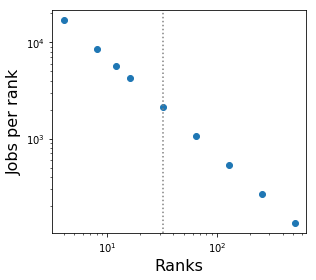

In [6]:
fig, axis = plt.subplots(figsize=(4.5, 4))
axis.scatter(mpi_ranks, num_jobs / np.array(mpi_ranks))
axis.axvline(x=32, color='grey', ls=':')
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlabel('Ranks', fontsize=16)
axis.set_ylabel('Jobs per rank', fontsize=16)
fig.tight_layout()

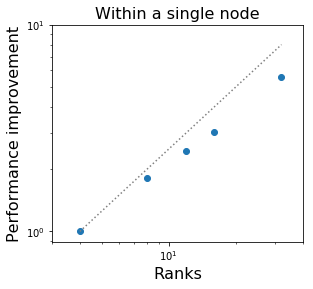

In [7]:
end_rank = np.argwhere(mpi_ranks == 32)[0][0]+1
fig, axis = plt.subplots(figsize=(4.5, 4))
axis.scatter(mpi_ranks[:end_rank], mpi_total_times[0] / mpi_total_times[:end_rank])
axis.plot(mpi_ranks[:end_rank], mpi_ranks[:end_rank]/mpi_ranks[0], color='grey', ls=':')
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlim(right=4E+1, left=3)
axis.set_ylim(top=10)
axis.set_ylabel('Performance improvement', fontsize=16)
axis.set_xlabel('Ranks', fontsize=16)
axis.set_title('Within a single node', fontsize=16);

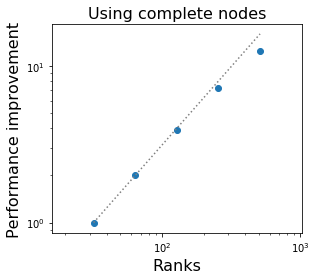

In [8]:
start_rank = np.argwhere(mpi_ranks == 32)[0][0]
fig, axis = plt.subplots(figsize=(4.5, 4))
axis.scatter(mpi_ranks[start_rank:], mpi_total_times[start_rank] / mpi_total_times[start_rank:])
axis.plot(mpi_ranks[start_rank:], mpi_ranks[start_rank:]/mpi_ranks[start_rank], color='grey', ls=':')
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlim(left=2**4, right=2**10)
axis.set_ylabel('Performance improvement', fontsize=16)
axis.set_xlabel('Ranks', fontsize=16)
axis.set_title('Using complete nodes', fontsize=16);
fig.tight_layout()

#axis_2 = axis.twiny()
#axis_2.set_xlabel('Nodes', fontsize=16)
#axis_2.set_xlim(axis.get_xlim())
#axis_2.set_xticks(ranks[start_rank:])
#axis_2.set_xticklabels([str(x) for x in ranks[start_rank:] / 32])
#

# Using Joblib

In [54]:
joblib_procs = []
joblib_compute_mean = []
joblib_compute_std = []
joblib_write_mean = []
joblib_write_std = []
joblib_total_times = []

prefix = 'GIVJoblib'
for file_name in os.listdir('.'):
    if not file_name.startswith(prefix): 
        continue
    nodes, ranks_per_node = parse_log_filename(file_name, prefix)
    compute_times, write_times, tot_time = parse_console_logs(file_name)
    """
    Note that compute time is measured for 1 rank
    It is going to look like just on worker finished so much work in X time
    In reality N workers together brought down the time. so:
    time_for_one_worker = time_for_n_workers * num_workers
    
    In mpi4py, each worker is independently profiled / timed whereas this is NOT possible in joblib
    What we can do for an apples-to-apples comparison is to scale the measured time per node by the number of workers
    """
    compute_times = np.array(compute_times) * ranks_per_node
    # Write times are indeed just ONE process writing to the file so no conversion is necessary
    joblib_procs.append(ranks_per_node)
    joblib_compute_mean.append(np.mean(compute_times))
    joblib_compute_std.append(np.std(compute_times))
    joblib_write_mean.append(np.mean(write_times))
    joblib_write_std.append(np.std(write_times))
    joblib_total_times.append(tot_time)

# This can be of any order so sort based on ranks:
sort_order = np.array(joblib_procs).argsort()

joblib_procs = np.array(joblib_procs)[sort_order]
joblib_compute_mean = np.array(joblib_compute_mean)[sort_order]
joblib_compute_std = np.array(joblib_compute_std)[sort_order]
joblib_write_mean = np.array(joblib_write_mean)[sort_order]
joblib_write_std = np.array(joblib_write_std)[sort_order]
joblib_total_times = np.array(joblib_total_times)[sort_order]

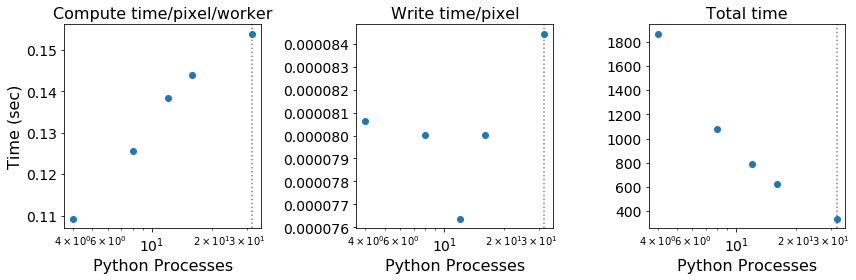

In [55]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
axes.flat[0].set_ylabel('Time (sec)', fontsize=16)
for axis, mean_vals, std_vals, qty_name in zip(axes.flat, 
                                              [joblib_compute_mean, joblib_write_mean, joblib_total_times],
                                              [joblib_compute_std, joblib_write_std, [0 for item in joblib_total_times]],
                                              ['Compute time/pixel/worker', 'Write time/pixel', 'Total time']):
    #axis.scatter(ranks, mean_vals)
    axis.errorbar(joblib_procs, mean_vals, yerr=std_vals, fmt='o')
    axis.set_xscale('log')
    axis.axvline(x=32, color='grey', ls=':')
    axis.set_title(qty_name, fontsize=16)
    axis.set_xlabel('Python Processes', fontsize=16)
    
usid.plot_utils.set_tick_font_size(axes, 14)
fig.tight_layout()

## Comparing joblib and mpi4py

### Write times
* In the case of joblib, the entire data is written by one process regardless of number of workers. So, the write time in theory should be invariant and this is what we see.
* It is cheapest to write all the data once. Writing N small chunks will be unnessarily slow. Moreover, N workers competing to write a chunk will make writes even slower. Therefore, in the case of mpi4py, the write time is expected to scale with the number of ranks. This is what we see.

### Compute times
* In the case of joblib, compute time is measured for 1 (the only) rank. It is going to look like just on worker finished so much work in X time. In reality N workers together brought down the time. In mpi4py, each worker is independently profiled / timed whereas this is NOT possible in joblib. What we can do for an apples-to-apples comparison is to scale the measured time per node by the number of workers
* Why exactly do we see compute time per worker per pixel rise with the number of workers?
    
    * One unfair comparison is that each run gave each worker different numbers of jobs. In fact, the product of the number of jobs per worker and the number of workers is constant.
    * Is it the cost associated with adding more workers? One way to find out is to simply fix the number of jobs for all workers. 

## Total time
* The most expensive operation is the compute time. Write time is negligible for small scales. Compute times for both mpi4py and joblib are comparable
* Total time is therefore identical whether the compute was through joblib or mpi4py

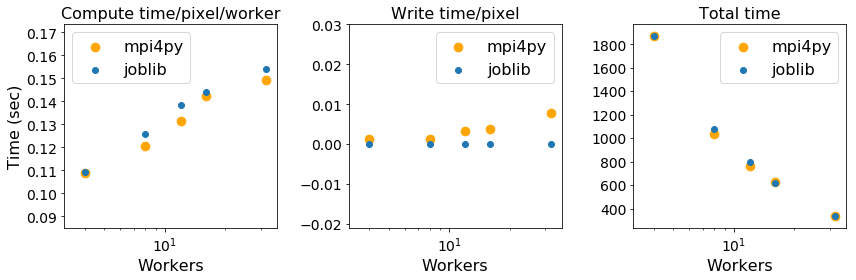

In [56]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
axes.flat[0].set_ylabel('Time (sec)', fontsize=16)
for axis, mean_vals in zip(axes.flat, [mpi_compute_mean, mpi_write_mean, mpi_total_times]):
    axis.scatter(mpi_ranks[:5], mean_vals[:5], color='orange', s=75, label='mpi4py')
    
for axis, mean_vals, qty_name in zip(axes.flat, 
                                     [joblib_compute_mean, joblib_write_mean, joblib_total_times],
                                     ['Compute time/pixel/worker', 'Write time/pixel', 'Total time']):
    #axis.scatter(ranks, mean_vals)
    axis.scatter(joblib_procs, mean_vals, label='joblib')
    axis.set_xscale('log')
    axis.set_title(qty_name, fontsize=16)
    axis.set_xlabel('Workers', fontsize=16)
    axis.legend(fontsize=16)
    
usid.plot_utils.set_tick_font_size(axes.flat, 14)
fig.tight_layout()

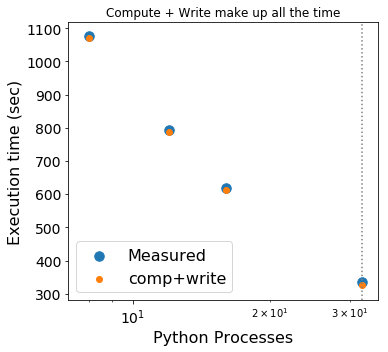

In [53]:
num_jobs = 68096
tot_time_per_pixel = np.array(joblib_compute_mean)  * joblib_procs + np.array(joblib_write_mean)
estimated_serial_time = num_jobs * tot_time_per_pixel
joblib_estimated_parallel_time = estimated_serial_time / np.array(joblib_procs)

fig, axis = plt.subplots(figsize=(5.5, 5))
axis.scatter(joblib_procs, joblib_total_times, s=90, label='Measured')
axis.scatter(joblib_procs, joblib_estimated_parallel_time, label='comp+write')
axis.set_xscale('log')
axis.axvline(x=32, color='grey', ls=':')
axis.set_xlabel('Python Processes', fontsize=16)
axis.set_ylabel('Execution time (sec)', fontsize=16)
axis.legend(fontsize=16)
axis.set_title('Compute + Write make up all the time')
usid.plot_utils.set_tick_font_size(axis, 14)
fig.tight_layout()